## Multimodal RAG using Langchain Expression Language And GPT4-Vision
https://medium.aiplanet.com/multimodal-rag-using-langchain-expression-language-and-gpt4-vision-8a94c8b02d21

### Install required dependencies

In [1]:
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install --quiet pdf2image pytesseract unstructured[all-docs] pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch
! pip install --quiet -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)
#! apt install poppler-utils
#! apt install tesseract-ocr

### Data Loading

In [2]:
import os

# import shutil
# os.mkdir("Masterpieces")
#! wget "https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf"
# shutil.move("0892360224.pdf","Masterpieces")

### Extract images and save it in the required path

In [3]:
path = "Masterpieces/"
file_name = "Masterpieces.pdf"

### Use partition_pdf method below from Unstructured to extract text and images

In [4]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=path + file_name,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Categorize text elements by type

In [5]:
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

print(len(tables))
print(len(texts))

2
194


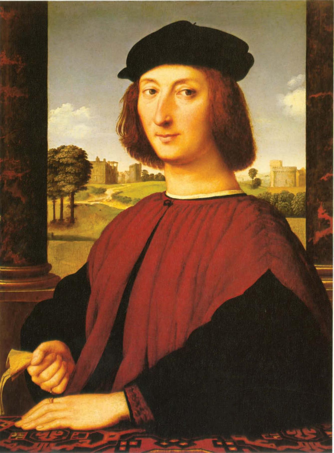

In [6]:
from PIL import Image
from IPython.display import display

# Open the image
img = Image.open(os.path.join(path, "figure-26-1.jpg"))

# Resize the image
resize_ratio = 0.25
new_size = (int(img.size[0] * resize_ratio), int(img.size[1] * resize_ratio))
img_resized = img.resize(new_size)

# Display the image
display(img_resized)

### Multi-modal embeddings with our document

In [7]:
from langchain_community.vectorstores.chroma import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_clip_photos", embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore.add_images(uris=image_uris)

# Add documents
vectorstore.add_texts(texts=texts)

# Make retriever
retriever = vectorstore.as_retriever(
    # search_kwargs={"k": 3},
)

### Retrieval Augmented Generation

In [8]:
import base64
import io


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

In [9]:
from operator import itemgetter

from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (
    RunnableLambda,
    RunnablePassthrough,
    RunnableParallel,
)


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As an expert art critic and historian, your task is to analyze and interpret images, "
            "considering their historical and cultural significance. Alongside the images, you will be "
            "provided with related text to offer context. Both will be retrieved from a vectorstore based "
            "on user-input keywords. Please use your extensive knowledge and analytical skills to provide a "
            "comprehensive summary that includes:\n"
            "- A detailed description of the visual elements in the image.\n"
            "- The historical and cultural context of the image.\n"
            "- An interpretation of the image's symbolism and meaning.\n"
            "- Connections between the image and the related text.\n\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]

### Return Source Documents

In [10]:
model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = {
    "context": retriever | RunnableLambda(split_image_text_types),
    "question": RunnablePassthrough(),
} | RunnableParallel(
    {
        "response": prompt_func | model | StrOutputParser(),
        "context": itemgetter("context"),
    }
)

### Invoke the RAG Question Answering Chain

### Helper function for displaying images related to the text retrieved

In [11]:
from IPython.display import HTML


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

In [12]:
def displayRAG(question):
    print("###QUESTION###")
    print(question, end="\n\n")

    response = chain.invoke(question)

    print("###ANSWER###")
    print(response["response"], end="\n\n")

    for i, image in enumerate(response["context"]["images"]):
        print(f"###IMAGE{i+1}###")
        plt_img_base64(image)

    for i, text in enumerate(response["context"]["texts"]):
        print(f"###TEXT{i+1}###")
        print(text, end="\n\n")

### Question 1

###QUESTION###
Hunting on the lagoon

###ANSWER###
The image depicts a serene scene of Venetian life during the Italian Renaissance, focusing on the activity of bird hunting on the lagoon. The painting is rich in detail, showing several boats with hunters dressed in red and white garments, which were typical of the period. The hunters are using long poles, perhaps to navigate through the shallow waters or to assist in the hunting process. Some of the figures are standing, aiming their weapons at the birds in flight, while others manage the boats or handle the birds. Notably, there are birds standing upright in the boats, which are identified as decoys used to attract other birds.

In the background, we see simple huts constructed from straw, suggesting temporary shelters for the hunters. The landscape is calm, with a sense of vast open space emphasized by the flat horizon line and the distant mountains. The sky is painted with soft clouds, contributing to the tranquil atmosphere of the


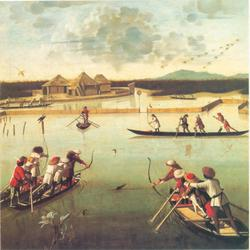

###TEXT1###
VITTORE  CARPACCIO Venetian, 1455/56-1525/26 Hunting  on the  Lagoon oil on panel, 75.9x63.7cm 6 Carpaccio  is considered to be the first great genre painter of the Italian Renaissance, and it is ob- vious that he was a careful observer of his surroundings. The  subject of this unusual painting is not yet completely understood, but it apparently depicts groups of Venetians, including some blacks, hunting for birds on the Venetian lagoon. Some birds standing upright in the boats must be decoys. In the background are huts built of straw, which the hunters must have used as temporary lodging. The  back of the painting shows an illusionistic cornice with some letters and memoranda—still legible—fastened  to the wall. The presence of a real hinge on the back indicates the painting was used as a door to a cupboard or more probably a window cover. It is therefore possible that one had the illusion of looking into the lagoon when the window was shuttered. The presence of a lily blo

In [13]:
displayRAG("Hunting on the lagoon")

### Question 2

In [14]:
displayRAG("Woman with children")

###QUESTION###
Woman with children

###ANSWER###
The image in question appears to be a portrait of a young woman, aged 21, with her children. The visual elements of the painting include the woman, who is the central figure, and her children who are surrounding her. The children are depicted in active poses, possibly playing musical instruments, which adds a sense of movement and liveliness to the composition. The painting is executed in oil on canvas and measures 94.4x114.2 cm.

The historical context of the image is that it was painted in 1632, during the Dutch Golden Age, a period known for its cultural and artistic achievements. The fact that the woman is 21 years old and has multiple children suggests that she may be from a wealthy or noble family, as it was common for women of higher social status to marry and have children at a young age during this time.

The symbolism and meaning of the image could be interpreted in several ways. The presence of the children and their musical i

### Question 3

###QUESTION###
Moses and the Messengers from Canaan



###ANSWER###
The image depicts a scene from the biblical story of Moses and the messengers from Canaan, as interpreted by the Italian Baroque painter Giovanni Lanfranco. The painting is rich in visual elements, with a group of figures gathered around a central point where large fruits are being presented. The figures are dressed in flowing robes, indicative of the biblical era, and their gestures and expressions convey a sense of wonder, curiosity, and perhaps debate over the findings from Canaan.

The historical and cultural context of this painting is deeply rooted in the religious narratives of the Old Testament. Lanfranco was an Italian painter active during the Baroque period, a time when religious themes dominated the arts. The painting was part of a series created for the Cappella del Sacramento in the church of S. Paolo Fuori le Mura in Rome, illustrating stories from the Old and New Testaments that related to the sacraments. This particular canvas was strategically placed to r


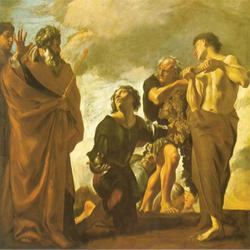

###IMAGE2###



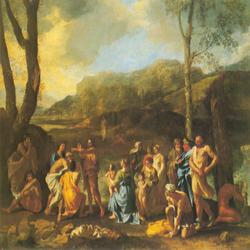

###TEXT1###
GIOVANNI  LANFRANCO Rome, 1582-1647 Moses  and  the  Messengers from  Canaan oil on canvas, 218 x246.3 cm 15  Between 1621 and 1625 Lanfranco executed a series of eight large paintings and three frescoes for the Cappella del Sacramento in the church of S. Paolo Fuori le Mura in Rome. They illustrated  stories from  the Old and New Testaments  that related  to the sacraments. The present  canvas belonged to the series and was hung high on the left wall just next to the entrance to the chapel. The  subject, which is rare, comes from  the book of  Numbers in which Moses sent spies into Canaan to find whether the land bore fruit.  After  forty days they returned with pomegranates, figs, and grapes. The  subject was chosen because the grapes were considered  a préfiguration of the wine drunk at  the Last Supper,  the  subject that hung to the right of our painting. Next  to that was Elias Fed a Loaf  of Bread by the Widow  ofSarepta,  a painting that is also in the Getty Museum 

In [15]:
displayRAG("Moses and the Messengers from Canaan")